In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
from scipy.sparse import csr_matrix
import time

# CPFM Sparse Storage Performance

This notebook aims to pinpoint which sparse storage method will be the most efficient for linear solver use, specifically `scipy.sparse.linalg.minres`. This work will inform how to most efficiently store the Laplacian discretization matrix for the $2^{nd}$ step of the CPFM algorithm. The RHS vector will be randomly generated via `numpy.random.rand`.  

In [2]:
# Callback functions required to see number of iterations 
    # from https://stackoverflow.com/questions/29747043/retrieving-number-of-iterations-that-ran-for-sparse-linear-solver-in-scipy

def iterations_minres(A, b):
    num_iters = 0
    
    def callback(xk):
        nonlocal num_iters
        num_iters+=1

    x,status = scipy.sparse.linalg.minres(A, b, tol=1e-10, callback=callback)
    return x,status,num_iters

## For 2D

The `laplace_matrix_2D_RD()` function from the `CPFM_2D.py` module is used to create the Laplacian discretization matrix.

In [3]:
def laplace_matrix_2D_RD(Nx, Ny):
    """
    Creates the 2D Laplacian discretization matrix for a rectangular domain,
        thereby allowing for cases where Nx =/= Ny 
    Input: Nx & Ny (int), number of grid points on x- & y-axes
    Output: A_matrix (float array), 2D Laplacian discretization matrix
    """
    # initialize the Laplacian discretization matrix
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    # iterate over the main diagonal
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4 # coefficient for current cell x_i,j 
        
        if (i > 0):
            A_matrix[i-1][i] = 1 # coefficient for right neighbor x_i+1,j 
            
            if (((i + 1) % Ny == 1) and (i < Nx * Ny - 1)):
                A_matrix[i-1][i] = 0 # remove non-existent right neighbor x_i+1,j 
                                        # when reaching the end of a row       
        if (i < Nx * Ny) and (i > 0):
            A_matrix[i][i-1] = 1 # coefficient for left neighbor x_i-1,j 
            
        if (((i + 1) % Ny == 1) and (i > 2)):
            A_matrix[i][i-1] = 0 # remove non-existent left neighbor x_i-1,j 
                                        # when reaching the end of a row
                
    # np.diag() to add coefficients for top (x_i,j-1) and bottom (x_i,j+1) neighbors respectively       
    A_matrix += np.diag(np.ones(Nx * Ny - Ny), -Ny) + np.diag(np.ones(Nx * Ny - Ny), Ny)
  
    return A_matrix

In [4]:
dimension_list = [10, 20, 30, 40, 50, 70, 80, 100, 120, 140, 160, 180, 200, 220]

# initialize plotting arrays
Na_array = np.array([])
iter_square_BSR = np.array([])  # MinRES - BSR
time_square_BSR = np.array([])
e_RMS_square_BSR = np.array([])
iter_square_COO = np.array([])  # MinRES - COO
time_square_COO = np.array([])
e_RMS_square_COO = np.array([])
iter_square_CSC = np.array([])  # MinRES - CSC
time_square_CSC = np.array([])
e_RMS_square_CSC = np.array([])
iter_square_CSR = np.array([])  # MinRES - CSR
time_square_CSR = np.array([])
e_RMS_square_CSR = np.array([])


for i in range(len(dimension_list)):
    
    Na = dimension_list[i]
    
    # construct random RHS vector
    vec_RHS = np.random.rand(Na**2)
    
    # construct sparsely stored square domain Laplacian discretization matrices
    A_square = laplace_matrix_2D_RD(Na, Na)
    A_square_BSR = scipy.sparse.bsr_matrix(A_square) # BSR (block sparse row)
    A_square_COO = scipy.sparse.coo_matrix(A_square) # COO (COOrdinate)
    A_square_CSC = scipy.sparse.csc_matrix(A_square) # CSC (compressed sparse column)
    A_square_CSR = scipy.sparse.csr_matrix(A_square) # CSR (compressed sparse row)
    
    
    # Data generation/collection portion : 
    Na_array = np.append(Na_array, Na)
    
    
    # For MinRES:
    # Square MinRES - BSR
    start = time.time() # start time
    solution_minres_BSR, s_minres, iter_minres = iterations_minres(A_square_BSR, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_BSR @ solution_minres_BSR)**2))
    
    iter_square_BSR = np.append(iter_square_BSR, iter_minres)
    time_square_BSR = np.append(time_square_BSR, end - start)
    e_RMS_square_BSR = np.append(e_RMS_square_BSR, e_RMS)
    
    # Square MinRES - COO
    start = time.time() # start time
    solution_minres_COO, s_minres, iter_minres = iterations_minres(A_square_COO, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_COO @ solution_minres_COO)**2))
    
    iter_square_COO = np.append(iter_square_COO, iter_minres)
    time_square_COO = np.append(time_square_COO, end - start)
    e_RMS_square_COO = np.append(e_RMS_square_COO, e_RMS)
    
    # Square MinRES - CSC
    start = time.time() # start time
    solution_minres_CSC, s_minres, iter_minres = iterations_minres(A_square_CSC, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_CSC @ solution_minres_CSC)**2))
    
    iter_square_CSC = np.append(iter_square_CSC, iter_minres)
    time_square_CSC = np.append(time_square_CSC, end - start)
    e_RMS_square_CSC = np.append(e_RMS_square_CSC, e_RMS)
    
    # Square MinRES - CSR
    start = time.time() # start time
    solution_minres_CSR, s_minres, iter_minres = iterations_minres(A_square_CSR, vec_RHS)
    end = time.time()   # end time
    
    e_RMS = (1.0/Na) * np.sqrt(np.sum((vec_RHS - A_square_CSR @ solution_minres_CSR)**2))
    
    iter_square_CSR = np.append(iter_square_CSR, iter_minres)
    time_square_CSR = np.append(time_square_CSR, end - start)
    e_RMS_square_CSR = np.append(e_RMS_square_CSR, e_RMS)
    
   

## Elapsed Time plots

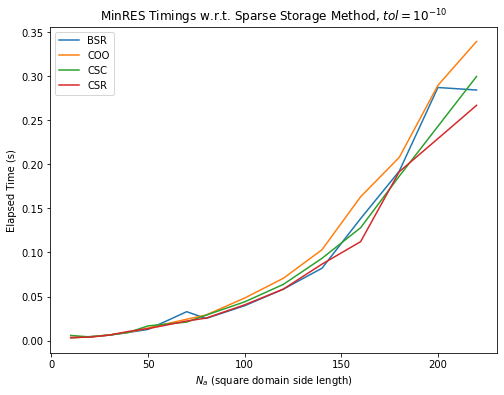

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_BSR, Na_array, time_square_COO, 
         Na_array, time_square_CSC, Na_array, time_square_CSR)
    
plt.title(r"MinRES Timings w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["BSR", "COO", "CSC", "CSR"])


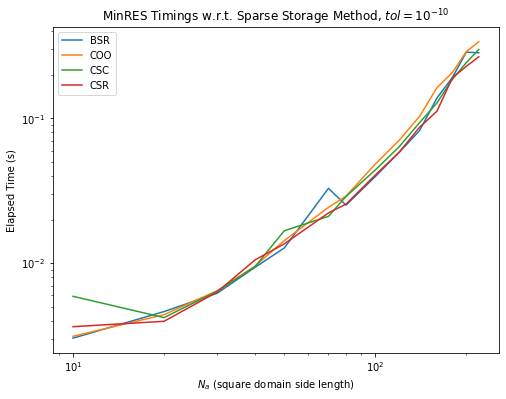

In [6]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_BSR, Na_array, time_square_COO, 
           Na_array, time_square_CSC, Na_array, time_square_CSR)
    
plt.title(r"MinRES Timings w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Elapsed Time (s)")
plt.legend(["BSR", "COO", "CSC", "CSR"])

## # of Iterations plots

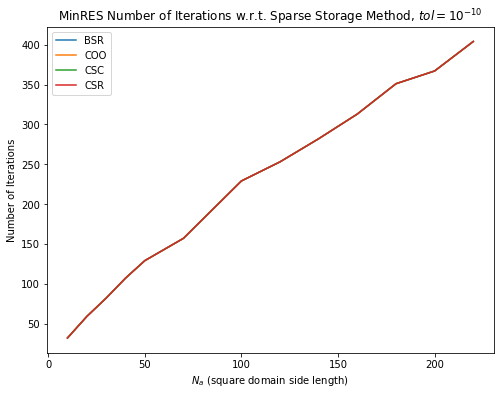

In [7]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, iter_square_BSR, Na_array, iter_square_COO, 
         Na_array, iter_square_CSC, Na_array, iter_square_CSR)
    
plt.title(r"MinRES Number of Iterations w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["BSR", "COO", "CSC", "CSR"])

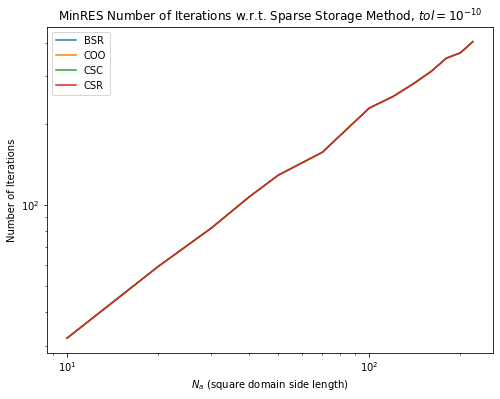

In [8]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, iter_square_BSR, Na_array, iter_square_COO, 
         Na_array, iter_square_CSC, Na_array, iter_square_CSR)
    
plt.title(r"MinRES Number of Iterations w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Number of Iterations")
plt.legend(["BSR", "COO", "CSC", "CSR"])

It is expected that the number of iterations will be independent on the sparse storage method for $A$ (only matrix size and linear solver type influence this).

## Time per Iteration plots

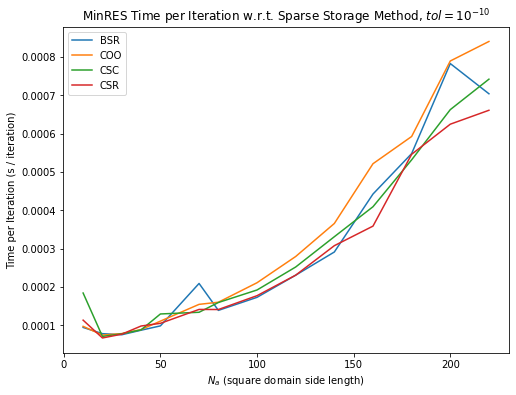

In [9]:
plt.figure(figsize=(8, 6))

plt.plot(Na_array, time_square_BSR/iter_square_BSR, Na_array, time_square_COO/iter_square_COO, 
         Na_array, time_square_CSC/iter_square_CSC, Na_array, time_square_CSR/iter_square_CSR)
    
plt.title(r"MinRES Time per Iteration w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["BSR", "COO", "CSC", "CSR"])

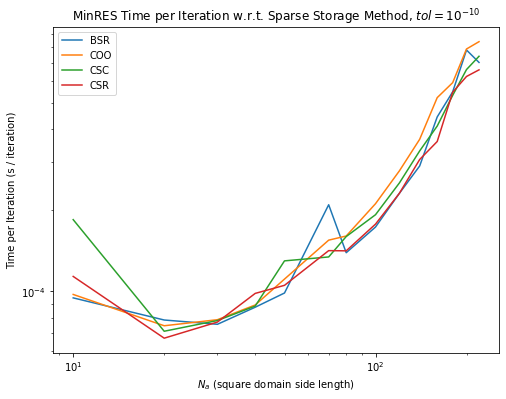

In [10]:
plt.figure(figsize=(8, 6))

plt.loglog(Na_array, time_square_BSR/iter_square_BSR, Na_array, time_square_COO/iter_square_COO, 
         Na_array, time_square_CSC/iter_square_CSC, Na_array, time_square_CSR/iter_square_CSR)
    
plt.title(r"MinRES Time per Iteration w.r.t. Sparse Storage Method, $tol = 10^{-10}$")
plt.xlabel(r"$N_a$ (square domain side length)")
plt.ylabel("Time per Iteration (s / iteration)")
plt.legend(["BSR", "COO", "CSC", "CSR"])